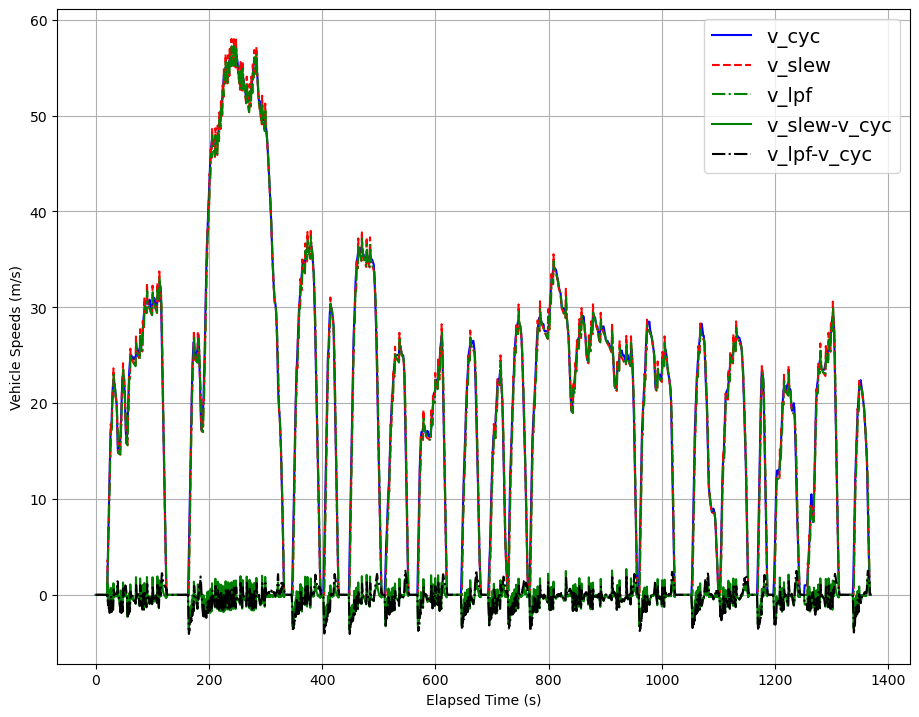

In [3]:
import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import sys
from scipy import interpolate

from driver import Driver
from controller import Controller
from vehicle import Vehicle
from battery_pack import Battery
from electric_motor import ElectricMotor
from gearbox import Gearbox
from front_brakes import FrontBrakes
from rear_brakes import RearBrakes
from front_wheels import FrontWheels
from rear_wheels import RearWheels
from first_order_filter import MinMaxSlewRateFilter
from first_order_filter import first_order_filter
from first_order_filter import butter_lowpass_filter

delta_t = 0.1
vehicle_mass = 3000 * 0.453592  # in kg

k_p = 0.1
k_i = 0.03  # 0.6
k_d = 0  # 2

k_p = 0.25 # ALPHA default
k_i = 0.1  # 0.6

density_air = 1.29
c_drag = 0.24
frontal_area = 3.5
em_efficiency = 0.95
em_gearbox_ratio = 18.63

brake_rear_proportion = 0.4
brake_front_proportion = 0.6

tire_radius = 0.465

driver = Driver(k_p, k_i, k_d, delta_t)
vehicle = Vehicle(vehicle_mass, density_air, c_drag, frontal_area, delta_t)
battery = Battery(0.6, 3, 120, delta_t)
em = ElectricMotor()
em_gearbox = Gearbox(em_efficiency, em_gearbox_ratio)
rear_brakes = RearBrakes(brake_rear_proportion, tire_radius)
front_brakes = FrontBrakes(brake_front_proportion, tire_radius)
rear_wheels = RearWheels(tire_radius)
front_wheels = FrontWheels(tire_radius)

vehspd = spio.loadmat('data/EPA_UDDS_spd.mat', squeeze_me=True)
v_cyc = np.array(vehspd['cycle_speed_mps'])
t_cyc = np.array(vehspd['cycle_time'])
# vehspd = spio.loadmat('data/v_cyc.mat', squeeze_me=True)
# v_cyc = np.array(vehspd['v_cyc'])
# t_cyc = np.array(vehspd['t_cyc'])

f_linear = interpolate.interp1d(t_cyc, v_cyc)

t_cyc = np.arange(0, np.max(t_cyc), delta_t)
v_cyc = f_linear(t_cyc)

dt = t_cyc[1] - t_cyc[0]
# print(dt)

# Apply the filter in 1st order filter
alpha_lpf = 0.25
v_slew_filter = MinMaxSlewRateFilter(min_slew_rate=-2.0, max_slew_rate=2.0)
v_out1 = []
v_slew = []

v_out = []
power_req_out = []
battery_power_out = []
em_torque_out = []
front_wheel_torque_out = []
rear_wheel_torque_out = []
force_at_wheel_out = []
front_brake_torque_out = []
rear_brake_torque_out = []
alpha = []
beta = []
v_p = []
v_i = []

for v, t in zip(v_cyc, t_cyc):
    driver_out = driver.compute_step(v, vehicle.velocity)

    # compute necessary battery power
    power_req = driver.alpha * battery.compute_max_power()
    power_req_out.append(power_req)

    b_out = battery.compute_step(power_req)
    battery_power_out.append(b_out['pack_power'])

    em.compute_step(battery.p_pack, em_gearbox.em_force_w)
    em_torque_out.append(em.em_torque)

    rear_brakes.compute_step(rear_wheels.wheel_torque, driver.beta)
    front_brakes.compute_step(front_wheels.wheel_torque, driver.beta)

    em_gearbox.compute_step(em.em_torque, front_brakes.front_brake_w)

    front_wheels.compute_step(
        em_gearbox.torque_out / 2, front_brakes.brake_torque, vehicle.velocity)

    rear_wheels.compute_step(
        em_gearbox.torque_out / 2, rear_brakes.brake_torque, vehicle.velocity)

    vehicle_data = vehicle.compute_step(front_wheels.force_at_wheel +
                                        rear_wheels.force_at_wheel, 0)

    # print(v, vehicle_data['velocity'])
    front_wheel_torque_out.append(front_wheels.wheel_torque)
    rear_wheel_torque_out.append(rear_wheels.wheel_torque)
    force_at_wheel_out.append(front_wheels.force_at_wheel +
                              rear_wheels.force_at_wheel)
    front_brake_torque_out.append(front_brakes.brake_torque)
    rear_brake_torque_out.append(rear_brakes.brake_torque)
    alpha.append(driver.alpha)
    beta.append(driver.beta)
    v_p.append(driver_out['v_p'])
    v_i.append(driver_out['v_i'])
    v_slew.append(v_slew_filter.filter(vehicle_data['velocity'], delta_t))
    v_out.append(vehicle_data['velocity'])


v_lpf = first_order_filter(v_slew, alpha_lpf)
v_filtered = list(filter(lambda x: 0 <= x <= np.inf, v_lpf))

delta_v = np.array(v_slew) - np.array(v_cyc)
delta_v1 = np.array(v_lpf) - np.array(v_cyc)
# plt.ion()
plt.close()

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(t_cyc, 2.23694*v_cyc, 'b-')
# plt.plot(t_cyc, v_out, 'r--')
plt.plot(t_cyc, 2.23694*np.array(v_slew), 'r--')
plt.plot(t_cyc, 2.23694*np.array(v_lpf), 'g-.')
plt.plot(t_cyc, 2.23694*delta_v, 'g-')
plt.plot(t_cyc, 2.23694*delta_v1, 'k-.')
plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Vehicle Speeds (m/s)')
plt.legend(['v_cyc', 'v_slew', 'v_lpf', 'v_slew-v_cyc', 'v_lpf-v_cyc'], fontsize=14, loc='upper right')

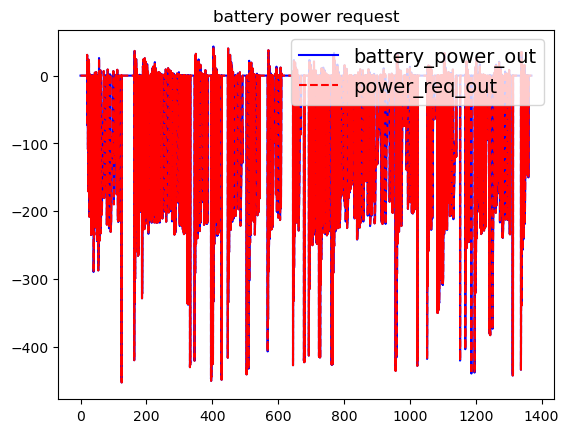

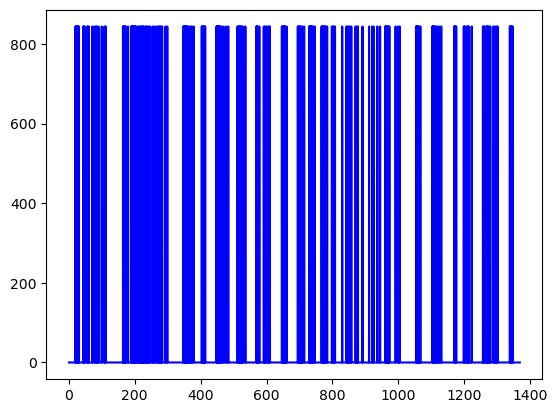

In [3]:
fig2 = plt.figure()
plt.title('battery power request')
plt.plot(t_cyc, battery_power_out, 'b')
plt.plot(t_cyc, power_req_out, 'r--')
# plt.legend('battery', 'power')
plt.legend(['battery_power_out', 'power_req_out'], fontsize=14, loc='upper right')

fig3 = plt.figure()
plt.plot(t_cyc, em_torque_out, 'b')

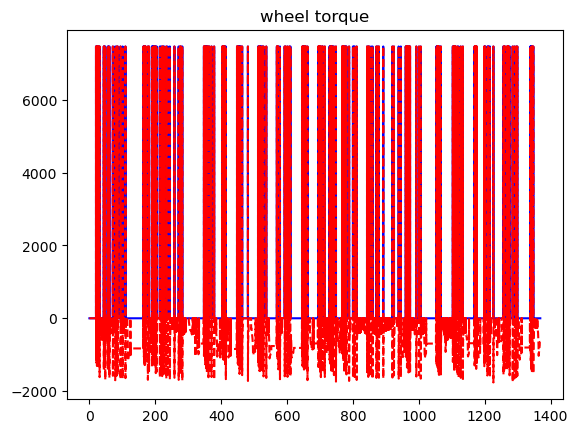

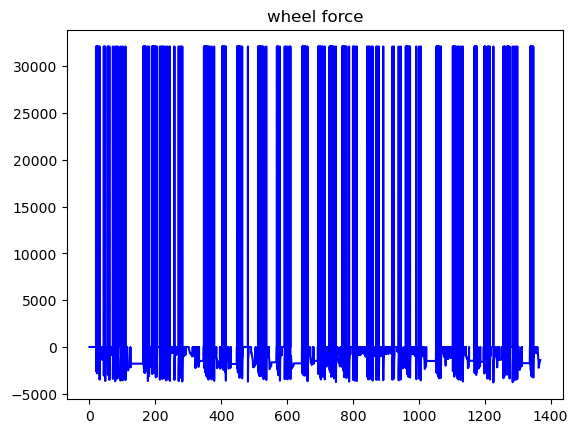

In [3]:
fig4 = plt.figure()
plt.title('wheel torque')
plt.plot(t_cyc, rear_wheel_torque_out, 'b')
plt.plot(t_cyc, front_wheel_torque_out, 'r--')


fig5 = plt.figure()
plt.title('wheel force')
plt.plot(t_cyc, force_at_wheel_out, 'b')

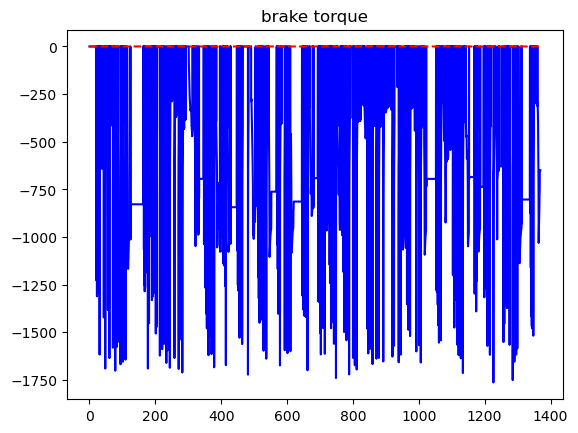

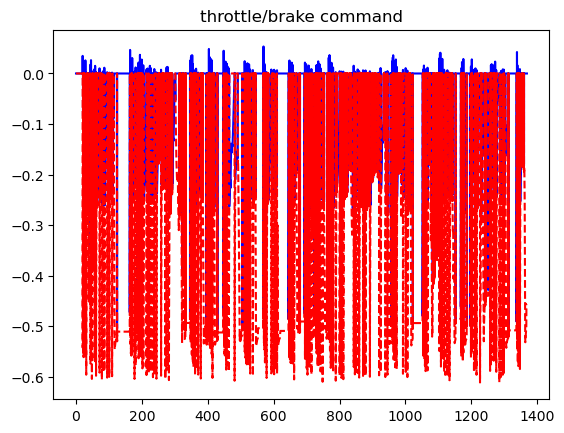

In [4]:
fig6 = plt.figure()
plt.title('brake torque')
plt.plot(t_cyc, front_brake_torque_out, 'b')
plt.plot(t_cyc, rear_brake_torque_out, 'r--')

fig7 = plt.figure()
plt.title('throttle/brake command')
plt.plot(t_cyc, alpha, 'b')
plt.plot(t_cyc, beta, 'r--')

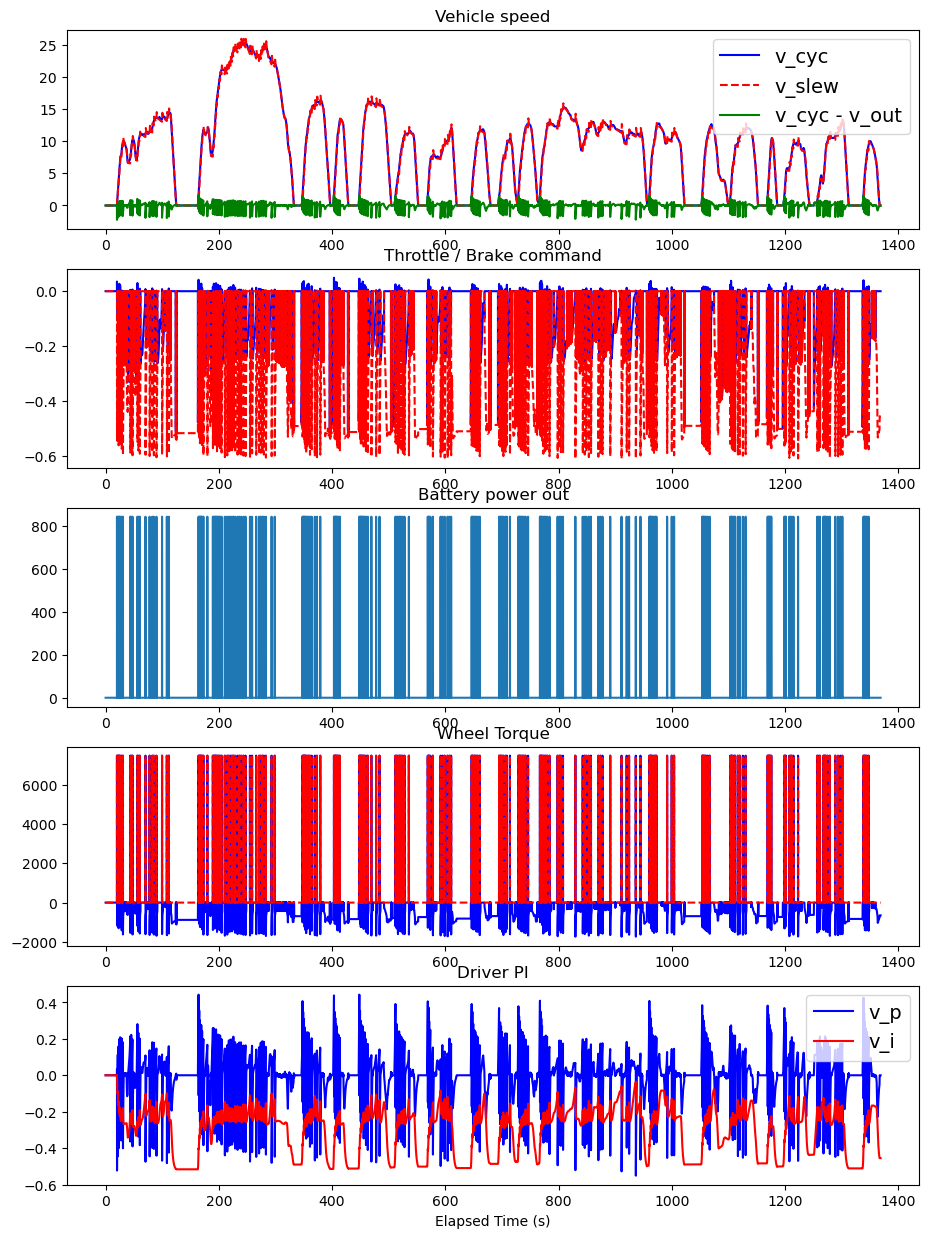

In [4]:
fig8 = plt.figure(figsize=(11, 15))

veh_speed = plt.subplot(511)
veh_speed.set_title('Vehicle speed')
veh_speed.plot(t_cyc, v_cyc, 'b')
veh_speed.plot(t_cyc, v_slew, 'r--')
veh_speed.plot(t_cyc, v_cyc - v_out, 'g')
plt.legend(['v_cyc', 'v_slew', 'v_cyc - v_out'], fontsize=14, loc='upper right')

acc_brake_cmd = plt.subplot(512, sharex=veh_speed)
acc_brake_cmd.set_title('Throttle / Brake command')
acc_brake_cmd.plot(t_cyc, alpha, 'b')
acc_brake_cmd.plot(t_cyc, beta, 'r--')

power_req = plt.subplot(513, sharex=veh_speed)
power_req.set_title('Battery power out')
power_req.plot(t_cyc, em_torque_out)


wheel_torque = plt.subplot(514, sharex=veh_speed)
wheel_torque.set_title('Wheel Torque')
wheel_torque.plot(t_cyc, front_wheel_torque_out, 'b')
wheel_torque.plot(t_cyc, rear_wheel_torque_out, 'r--')

driver_pi = plt.subplot(515, sharex=veh_speed)
driver_pi.set_title('Driver PI')
driver_pi.plot(t_cyc, v_p, 'b')
driver_pi.plot(t_cyc, v_i, 'r')
plt.xlabel('Elapsed Time (s)')
plt.legend(['v_p', 'v_i'], fontsize=14, loc='upper right')
# plt.show()

plt.show()

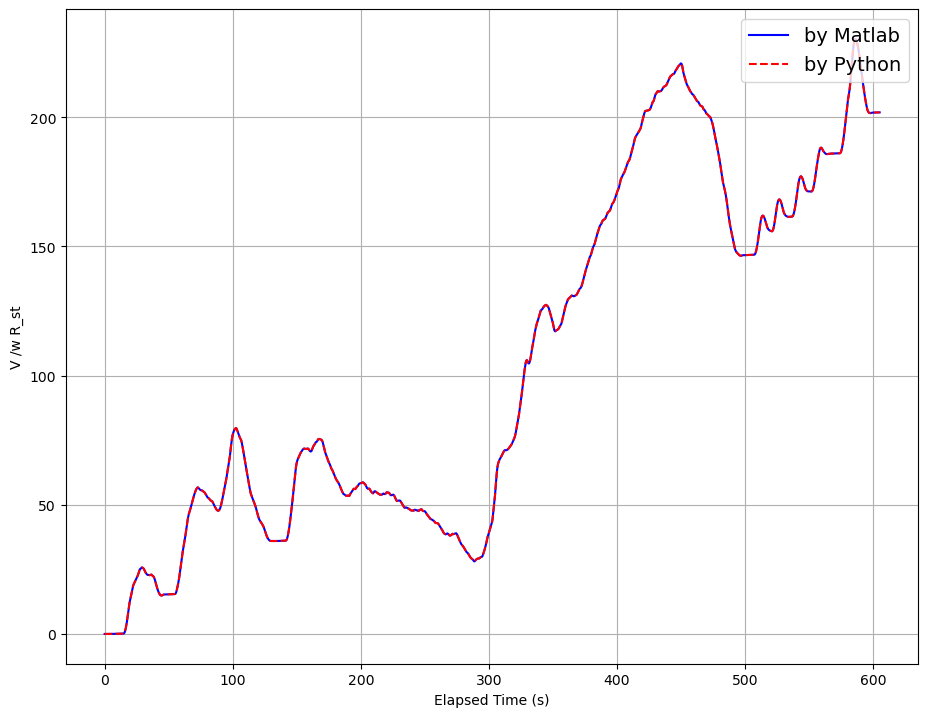

In [5]:
RC_ST_V = spio.loadmat('data/RC_ST_V.mat', squeeze_me=True)
RC_ST_V_t = RC_ST_V['t']
RC_ST_V_in = RC_ST_V['in']
RC_ST_V_out = RC_ST_V['out']
dt1 = RC_ST_V_t[1] - RC_ST_V_t[0]

RC_ST_V_out1 = np.zeros(len(RC_ST_V_out))
for i in range(len(RC_ST_V_t)):
    t = RC_ST_V_t[i]
    icurr = RC_ST_V_in[i]
    if i == 0:
        RC_ST_V_out1[i] = 0 # icurr * dt1
    else:
        RC_ST_V_out1[i] = RC_ST_V_out1[i-1] + icurr * dt1

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(RC_ST_V_t, RC_ST_V_out, 'b-')
plt.plot(RC_ST_V_t, RC_ST_V_out1, 'r--')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('V /w R_st')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')

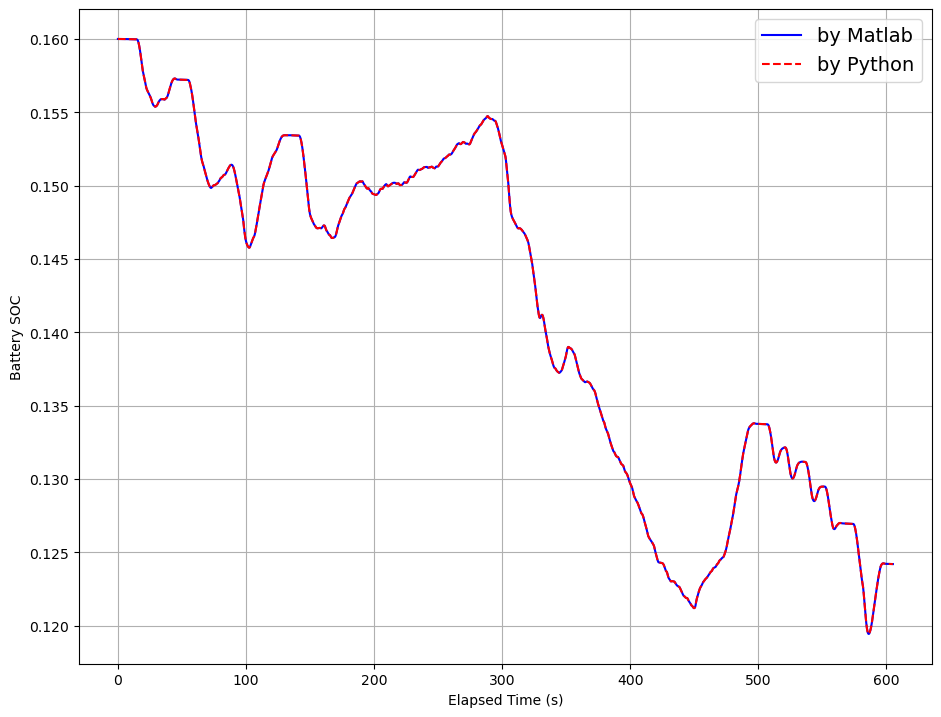

In [6]:
import numpy as np

batt_data = spio.loadmat('data/batt_data.mat', squeeze_me=True)
batt_data_t = batt_data['t']
batt_data_curr_in = batt_data['curr_in']
batt_data_soc = batt_data['soc']
dt1 = batt_data_t[1] - batt_data_t[0]

batt_soc1 = np.zeros(len(batt_data_t))
batt_capacity_s = 378000 # 52.5Ah * 2 parallel * 3600 sec
for i in range(len(batt_data_t)):
    t = batt_data_t[i]
    icurr = - batt_data_curr_in[i]
    if i == 0:
        batt_soc1[i] = batt_data_soc[0] # icurr * dt1
    else:
        batt_soc1[i] = batt_soc1[i-1] + (icurr/batt_capacity_s) * dt1

    if batt_soc1[i] > 0.99: batt_soc1[i] = 0.99
        
fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(batt_data_t, batt_data_soc, 'b-')
plt.plot(batt_data_t, batt_soc1, 'r--')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Battery SOC')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')

dt1 = 0.01  size of t_cyc = 60502


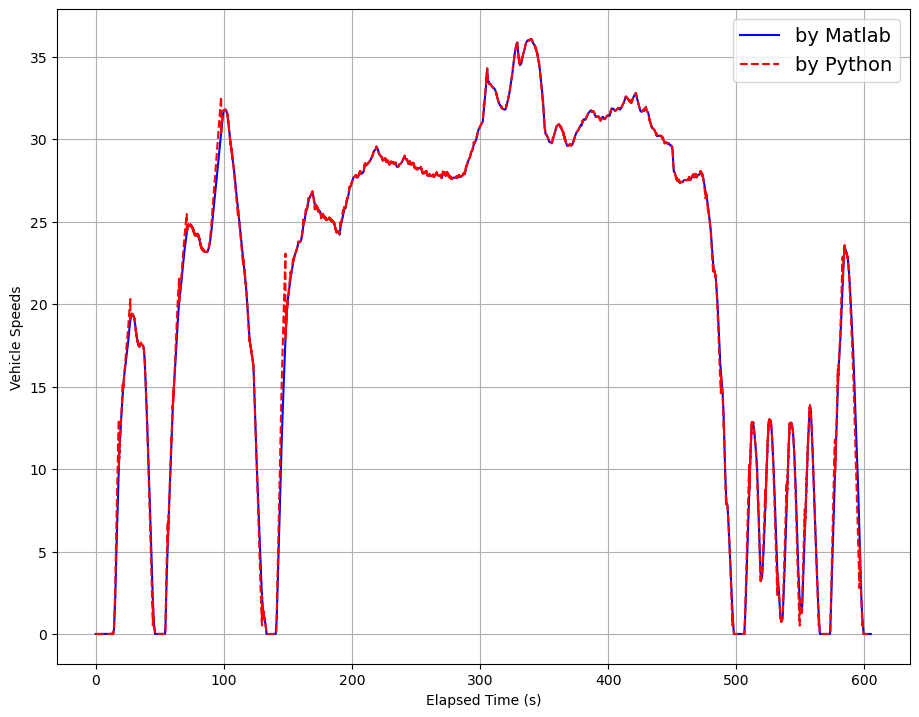

In [40]:
veh_data = spio.loadmat('data/veh_data.mat', squeeze_me=True)
veh_data_t = veh_data['t']
veh_data_tract_force_N = veh_data['tract_force_N']
veh_data_mass_kg = veh_data['mass_kg']
vehspd_mps = veh_data['spd_mps']
veh_data_dist_m = veh_data['dist_m']
dt1 = veh_data_t[1] - veh_data_t[0]

vehspd_mps1 = np.zeros(len(veh_data_t))
veh_data_dist_m1 = np.zeros(len(veh_data_t))
print('dt1 =', dt1, ' size of t_cyc =', len(veh_data_t))

for i in range(len(veh_data_t)):
    a_out_i = veh_data_tract_force_N[i] / veh_data_mass_kg[i]
    if i == 0:
        vehspd_mps1[i] = 0
        veh_data_dist_m1[i] = 0
    else:
        vehspd_mps1[i] = vehspd_mps1[i - 1] + a_out_i * dt1
        a_delta = ((vehspd_mps[i] - vehspd_mps[i - 1]) / dt1) - a_out_i
        v_delta = vehspd_mps1[i] - vehspd_mps[i]
        if (vehspd_mps1[i] > 0) and (a_out_i != a_delta) and (np.abs(v_delta) > 0.01):
            if (v_delta > 0) and (abs(a_delta) <= 0.1):
                vehspd_mps1[i] = vehspd_mps1[i] - v_delta
            elif (v_delta < 0) and (abs(a_delta) <= 0.1):
                vehspd_mps1[i] = vehspd_mps1[i] + 0.1

        if (vehspd_mps1[i] < 0.1): vehspd_mps1[i] = 0.0

        if (vehspd_mps1[i] < 0.5) and (vehspd_mps[i] > 0.5):
            vehspd_mps1[i] = vehspd_mps[i]

        veh_data_dist_m1[i] = veh_data_dist_m1[i - 1] + vehspd_mps1[i] * dt1

fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(veh_data_t, vehspd_mps, 'b-')
plt.plot(veh_data_t, vehspd_mps1, 'r--')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Vehicle Speeds')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper right')


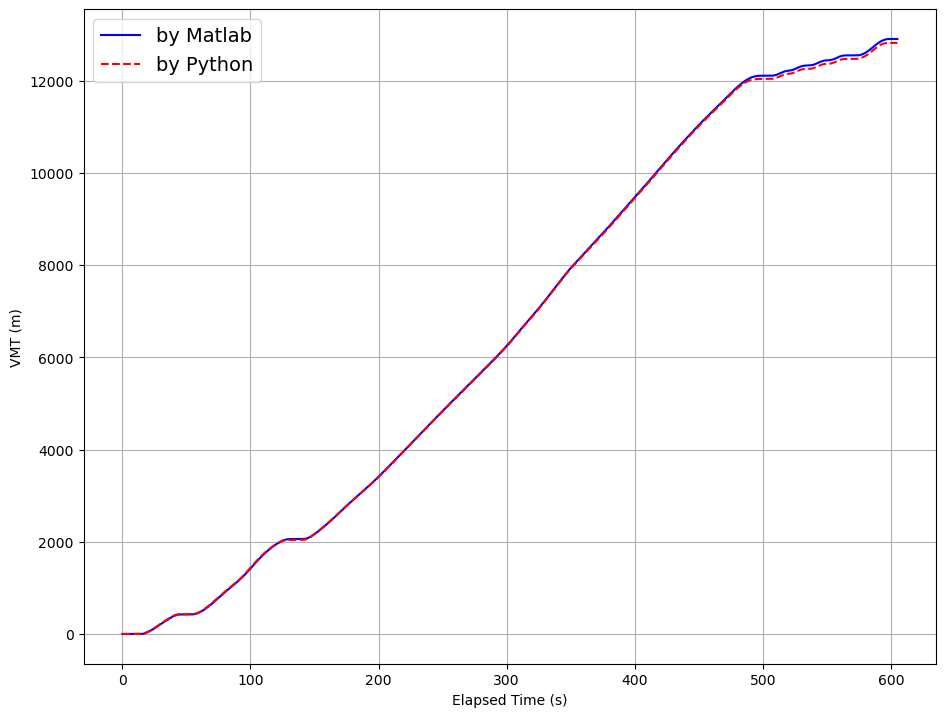

In [28]:
fig1 = plt.figure(figsize=(11, 8.5))
plt.plot(veh_data_t, veh_data_dist_m, 'b-')
plt.plot(veh_data_t, veh_data_dist_m1, 'r--')

plt.grid()
plt.xlabel('Elapsed Time (s)')
plt.ylabel('VMT (m)')
plt.legend(['by Matlab', 'by Python'], fontsize=14, loc='upper left')